In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as sct

import tensorflow as tf
import pickle as pkl
import tensorflow as tf


In [2]:
mean = (0,0) 
cov = [[1, .5], [.5, 1]]
samples = 1000
x = np.random.multivariate_normal(mean, cov, (1, samples))


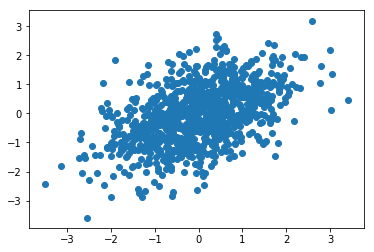

In [3]:
plt.scatter(x[0,:,0],x[0,:,1])
plt.show()

In [4]:
u,v = (sct.norm.cdf(x[0,:,0])),(sct.norm.cdf(x[0,:,1]))

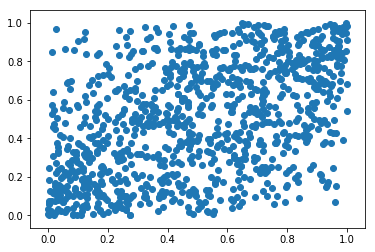

In [5]:
plt.scatter(u,v)
plt.show()

In [6]:
uv_mat =np.transpose(np.array([u,v]))
uv_mat

array([[ 0.35008537,  0.30033006],
       [ 0.2502236 ,  0.29166465],
       [ 0.55846985,  0.17431664],
       ..., 
       [ 0.65602683,  0.93376557],
       [ 0.66148876,  0.69539358],
       [ 0.2909818 ,  0.76160332]])

In [7]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, 2), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [8]:
def generator(z, out_dim, n_units=4, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Hidden layer 2
        h2 = tf.layers.dense(h1, n_units, activation=None)
        # Leaky ReLU
        h2 = tf.maximum(alpha * h2, h2)
        
        # Logits and tanh output
        logits = tf.layers.dense(h2, out_dim, activation=None)
        out = tf.sigmoid(logits)
        
        return out

In [9]:
def discriminator(x, n_units=4, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
         # Hidden layer 1
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Hidden layer 2
        h2 = tf.layers.dense(h1, n_units, activation=None)
        # Leaky ReLU
        h2 = tf.maximum(alpha * h2, h2)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [10]:
# Size of input image to discriminator
input_size = 2
# Size of latent vector to generator
z_size = 8
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 16
d_hidden_size = 16
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.01

In [11]:
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
# g_model is the generator output

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

In [12]:
# Calculate losses
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

In [13]:
# Optimizers
learning_rate = 0.001

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [14]:
def batches(uv_mat,batch_size):
    idx = np.arange(len(uv_mat))
    np.random.shuffle(idx)
    train_x = uv_mat[idx]

    n_batches = len(train_x)//batch_size
    for ii in range(0, len(train_x), batch_size):
        x = train_x[ii:ii+batch_size]
        yield np.reshape(x, (batch_size,2))
    

In [15]:
batch_size = 256
epochs = 1000
samples = []
losses = []
num_samples = uv_mat.shape[0]
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(num_samples//batch_size):
            batch = next(batches(uv_mat,batch_size))  
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch
             
            # Sample random noise for G
            batch_z = np.random.uniform(0, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(0, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/1000... Discriminator Loss: 1.3826... Generator Loss: 0.7112
Epoch 2/1000... Discriminator Loss: 1.3803... Generator Loss: 0.7104
Epoch 3/1000... Discriminator Loss: 1.3783... Generator Loss: 0.7101
Epoch 4/1000... Discriminator Loss: 1.3752... Generator Loss: 0.7104
Epoch 5/1000... Discriminator Loss: 1.3751... Generator Loss: 0.7110
Epoch 6/1000... Discriminator Loss: 1.3731... Generator Loss: 0.7110
Epoch 7/1000... Discriminator Loss: 1.3734... Generator Loss: 0.7119
Epoch 8/1000... Discriminator Loss: 1.3736... Generator Loss: 0.7118
Epoch 9/1000... Discriminator Loss: 1.3699... Generator Loss: 0.7100
Epoch 10/1000... Discriminator Loss: 1.3710... Generator Loss: 0.7082
Epoch 11/1000... Discriminator Loss: 1.3749... Generator Loss: 0.7064
Epoch 12/1000... Discriminator Loss: 1.3738... Generator Loss: 0.7047
Epoch 13/1000... Discriminator Loss: 1.3758... Generator Loss: 0.7047
Epoch 14/1000... Discriminator Loss: 1.3749... Generator Loss: 0.7040
Epoch 15/1000... Discriminato

Epoch 118/1000... Discriminator Loss: 1.2987... Generator Loss: 0.8020
Epoch 119/1000... Discriminator Loss: 1.3075... Generator Loss: 0.7827
Epoch 120/1000... Discriminator Loss: 1.3060... Generator Loss: 0.7677
Epoch 121/1000... Discriminator Loss: 1.3442... Generator Loss: 0.7540
Epoch 122/1000... Discriminator Loss: 1.3637... Generator Loss: 0.7431
Epoch 123/1000... Discriminator Loss: 1.3656... Generator Loss: 0.7387
Epoch 124/1000... Discriminator Loss: 1.3645... Generator Loss: 0.7369
Epoch 125/1000... Discriminator Loss: 1.3741... Generator Loss: 0.7387
Epoch 126/1000... Discriminator Loss: 1.3852... Generator Loss: 0.7419
Epoch 127/1000... Discriminator Loss: 1.3773... Generator Loss: 0.7463
Epoch 128/1000... Discriminator Loss: 1.3828... Generator Loss: 0.7494
Epoch 129/1000... Discriminator Loss: 1.3746... Generator Loss: 0.7541
Epoch 130/1000... Discriminator Loss: 1.3723... Generator Loss: 0.7568
Epoch 131/1000... Discriminator Loss: 1.3545... Generator Loss: 0.7610
Epoch 

Epoch 234/1000... Discriminator Loss: 1.1932... Generator Loss: 0.8846
Epoch 235/1000... Discriminator Loss: 1.1865... Generator Loss: 0.8826
Epoch 236/1000... Discriminator Loss: 1.1908... Generator Loss: 0.8788
Epoch 237/1000... Discriminator Loss: 1.1970... Generator Loss: 0.8694
Epoch 238/1000... Discriminator Loss: 1.2011... Generator Loss: 0.8660
Epoch 239/1000... Discriminator Loss: 1.1895... Generator Loss: 0.8572
Epoch 240/1000... Discriminator Loss: 1.2087... Generator Loss: 0.8449
Epoch 241/1000... Discriminator Loss: 1.2114... Generator Loss: 0.8322
Epoch 242/1000... Discriminator Loss: 1.2144... Generator Loss: 0.8175
Epoch 243/1000... Discriminator Loss: 1.2300... Generator Loss: 0.8030
Epoch 244/1000... Discriminator Loss: 1.2376... Generator Loss: 0.7804
Epoch 245/1000... Discriminator Loss: 1.2602... Generator Loss: 0.7558
Epoch 246/1000... Discriminator Loss: 1.2801... Generator Loss: 0.7329
Epoch 247/1000... Discriminator Loss: 1.3130... Generator Loss: 0.7098
Epoch 

Epoch 350/1000... Discriminator Loss: 1.3098... Generator Loss: 0.7558
Epoch 351/1000... Discriminator Loss: 1.2978... Generator Loss: 0.7583
Epoch 352/1000... Discriminator Loss: 1.2929... Generator Loss: 0.7631
Epoch 353/1000... Discriminator Loss: 1.2937... Generator Loss: 0.7695
Epoch 354/1000... Discriminator Loss: 1.2945... Generator Loss: 0.7770
Epoch 355/1000... Discriminator Loss: 1.2897... Generator Loss: 0.7857
Epoch 356/1000... Discriminator Loss: 1.2831... Generator Loss: 0.7916
Epoch 357/1000... Discriminator Loss: 1.2807... Generator Loss: 0.7944
Epoch 358/1000... Discriminator Loss: 1.2785... Generator Loss: 0.7965
Epoch 359/1000... Discriminator Loss: 1.2758... Generator Loss: 0.7972
Epoch 360/1000... Discriminator Loss: 1.2706... Generator Loss: 0.8005
Epoch 361/1000... Discriminator Loss: 1.2540... Generator Loss: 0.8072
Epoch 362/1000... Discriminator Loss: 1.2488... Generator Loss: 0.8155
Epoch 363/1000... Discriminator Loss: 1.2491... Generator Loss: 0.8157
Epoch 

Epoch 466/1000... Discriminator Loss: 1.2972... Generator Loss: 0.7307
Epoch 467/1000... Discriminator Loss: 1.2934... Generator Loss: 0.7313
Epoch 468/1000... Discriminator Loss: 1.2897... Generator Loss: 0.7319
Epoch 469/1000... Discriminator Loss: 1.2877... Generator Loss: 0.7327
Epoch 470/1000... Discriminator Loss: 1.2866... Generator Loss: 0.7334
Epoch 471/1000... Discriminator Loss: 1.2818... Generator Loss: 0.7343
Epoch 472/1000... Discriminator Loss: 1.2799... Generator Loss: 0.7349
Epoch 473/1000... Discriminator Loss: 1.2739... Generator Loss: 0.7362
Epoch 474/1000... Discriminator Loss: 1.2717... Generator Loss: 0.7370
Epoch 475/1000... Discriminator Loss: 1.2765... Generator Loss: 0.7384
Epoch 476/1000... Discriminator Loss: 1.2650... Generator Loss: 0.7397
Epoch 477/1000... Discriminator Loss: 1.2647... Generator Loss: 0.7409
Epoch 478/1000... Discriminator Loss: 1.2622... Generator Loss: 0.7421
Epoch 479/1000... Discriminator Loss: 1.2608... Generator Loss: 0.7435
Epoch 

Epoch 582/1000... Discriminator Loss: 1.4726... Generator Loss: 0.7600
Epoch 583/1000... Discriminator Loss: 1.4726... Generator Loss: 0.7636
Epoch 584/1000... Discriminator Loss: 1.4691... Generator Loss: 0.7668
Epoch 585/1000... Discriminator Loss: 1.4697... Generator Loss: 0.7704
Epoch 586/1000... Discriminator Loss: 1.4625... Generator Loss: 0.7738
Epoch 587/1000... Discriminator Loss: 1.4514... Generator Loss: 0.7773
Epoch 588/1000... Discriminator Loss: 1.4532... Generator Loss: 0.7809
Epoch 589/1000... Discriminator Loss: 1.4543... Generator Loss: 0.7847
Epoch 590/1000... Discriminator Loss: 1.4394... Generator Loss: 0.7884
Epoch 591/1000... Discriminator Loss: 1.4436... Generator Loss: 0.7926
Epoch 592/1000... Discriminator Loss: 1.4329... Generator Loss: 0.7964
Epoch 593/1000... Discriminator Loss: 1.4249... Generator Loss: 0.8004
Epoch 594/1000... Discriminator Loss: 1.4291... Generator Loss: 0.8043
Epoch 595/1000... Discriminator Loss: 1.4152... Generator Loss: 0.8083
Epoch 

Epoch 698/1000... Discriminator Loss: 1.4954... Generator Loss: 0.6395
Epoch 699/1000... Discriminator Loss: 1.4997... Generator Loss: 0.6397
Epoch 700/1000... Discriminator Loss: 1.4988... Generator Loss: 0.6387
Epoch 701/1000... Discriminator Loss: 1.4992... Generator Loss: 0.6386
Epoch 702/1000... Discriminator Loss: 1.4888... Generator Loss: 0.6395
Epoch 703/1000... Discriminator Loss: 1.4869... Generator Loss: 0.6391
Epoch 704/1000... Discriminator Loss: 1.4917... Generator Loss: 0.6394
Epoch 705/1000... Discriminator Loss: 1.4923... Generator Loss: 0.6391
Epoch 706/1000... Discriminator Loss: 1.4957... Generator Loss: 0.6395
Epoch 707/1000... Discriminator Loss: 1.4799... Generator Loss: 0.6393
Epoch 708/1000... Discriminator Loss: 1.4858... Generator Loss: 0.6397
Epoch 709/1000... Discriminator Loss: 1.4840... Generator Loss: 0.6403
Epoch 710/1000... Discriminator Loss: 1.4841... Generator Loss: 0.6405
Epoch 711/1000... Discriminator Loss: 1.4692... Generator Loss: 0.6406
Epoch 

Epoch 814/1000... Discriminator Loss: 1.4668... Generator Loss: 0.6322
Epoch 815/1000... Discriminator Loss: 1.4671... Generator Loss: 0.6371
Epoch 816/1000... Discriminator Loss: 1.4637... Generator Loss: 0.6416
Epoch 817/1000... Discriminator Loss: 1.4595... Generator Loss: 0.6467
Epoch 818/1000... Discriminator Loss: 1.4605... Generator Loss: 0.6534
Epoch 819/1000... Discriminator Loss: 1.4589... Generator Loss: 0.6601
Epoch 820/1000... Discriminator Loss: 1.4695... Generator Loss: 0.6660
Epoch 821/1000... Discriminator Loss: 1.4627... Generator Loss: 0.6744
Epoch 822/1000... Discriminator Loss: 1.4626... Generator Loss: 0.6823
Epoch 823/1000... Discriminator Loss: 1.4621... Generator Loss: 0.6900
Epoch 824/1000... Discriminator Loss: 1.4660... Generator Loss: 0.6978
Epoch 825/1000... Discriminator Loss: 1.4565... Generator Loss: 0.7060
Epoch 826/1000... Discriminator Loss: 1.4591... Generator Loss: 0.7152
Epoch 827/1000... Discriminator Loss: 1.4552... Generator Loss: 0.7236
Epoch 

Epoch 930/1000... Discriminator Loss: 1.4462... Generator Loss: 0.6354
Epoch 931/1000... Discriminator Loss: 1.4431... Generator Loss: 0.6344
Epoch 932/1000... Discriminator Loss: 1.4423... Generator Loss: 0.6336
Epoch 933/1000... Discriminator Loss: 1.4449... Generator Loss: 0.6325
Epoch 934/1000... Discriminator Loss: 1.4526... Generator Loss: 0.6320
Epoch 935/1000... Discriminator Loss: 1.4434... Generator Loss: 0.6310
Epoch 936/1000... Discriminator Loss: 1.4497... Generator Loss: 0.6303
Epoch 937/1000... Discriminator Loss: 1.4460... Generator Loss: 0.6300
Epoch 938/1000... Discriminator Loss: 1.4482... Generator Loss: 0.6298
Epoch 939/1000... Discriminator Loss: 1.4500... Generator Loss: 0.6297
Epoch 940/1000... Discriminator Loss: 1.4487... Generator Loss: 0.6296
Epoch 941/1000... Discriminator Loss: 1.4526... Generator Loss: 0.6299
Epoch 942/1000... Discriminator Loss: 1.4544... Generator Loss: 0.6295
Epoch 943/1000... Discriminator Loss: 1.4450... Generator Loss: 0.6306
Epoch 

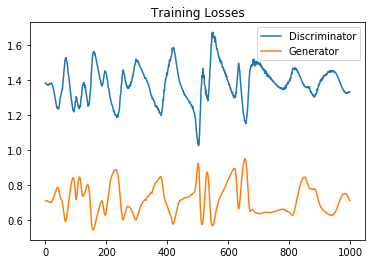

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [17]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

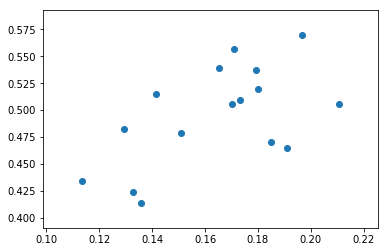

In [18]:
u,v = samples[-1][:,0],samples[-1][:,1]
plt.scatter(u,v)
plt.show()

In [19]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(0, 1, size=(1000, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


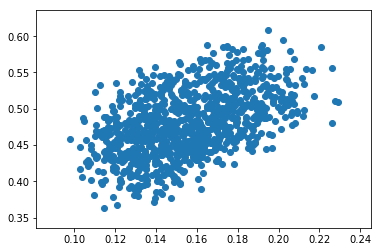

In [20]:
u,v = gen_samples[:,0],gen_samples[:,1]

plt.scatter(u,v)
plt.show()